In [14]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *


sim_name = f"Dopri5_1k"
sim_folder = f"sim_output/{sim_name}"
nu_mass_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
sim_data = SimData(sim_folder)

# Simulation parameters.
with open(f'{sim_folder}/sim_parameters.yaml', 'r') as file:
    sim_setup = yaml.safe_load(file)
Nside = sim_setup["Nside"]
Npix = sim_setup["Npix"]
nu_per_pix = sim_setup["momentum_num"]
pix_sr = sim_setup["pix_sr"]

exclude_nums = [
    20,  # broken halo
    25,  #? halo with only underdensities? look at skymap for this one...
]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Overdensity band

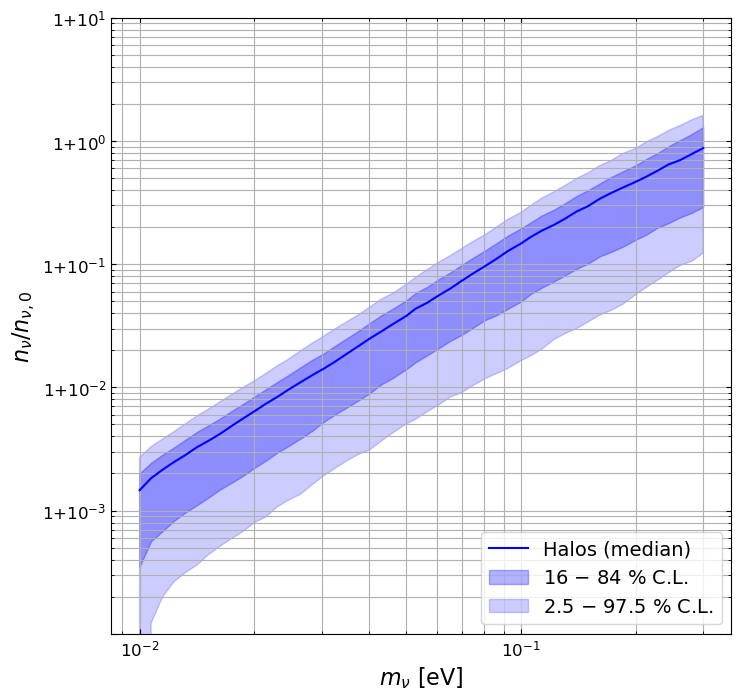

In [2]:
tot_dens_halos = jnp.load(f"{sim_folder}/total_densities.npy")
SimPlot.overdensity_band(
    dens_arr=tot_dens_halos,
    m_arr=nu_mass_range,
    plot_ylims=(1e-4,1e1),
    fig_path=f"figures/overdensity_band_{sim_name}.pdf",
    args=Params())

## Anisotropy Skymaps and Power Spectra

In [3]:
nu_vectors = jnp.load(f"{sim_folder}/vectors_halo1.npy")
ic(nu_vectors.shape)

nu_dens = Physics.number_densities_all_sky(
    v_arr=nu_vectors[..., 3:],
    m_arr=nu_mass_range,
    pix_sr=pix_sr,
    args=Params())
ic(nu_dens.shape)

ic| nu_vectors.shape: (768, 1000, 2, 6)
ic| nu_dens.shape: (50, 768)


(50, 768)

ic| CNB_dens_1mass.shape: (768,)
ic| CNB_dens_1mass.min(): Array(0.03622775, dtype=float64)
    CNB_dens_1mass.max(): Array(0.57511279, dtype=float64)
/home/fabian/anaconda3/envs/dev/lib/python3.12/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': 0, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/fabian/anaconda3/envs/dev/lib/python3.12/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.1, 'cbar_label_pad': 0, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")
/home/fabian/anaconda3/envs/dev/lib/python3.12/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies:

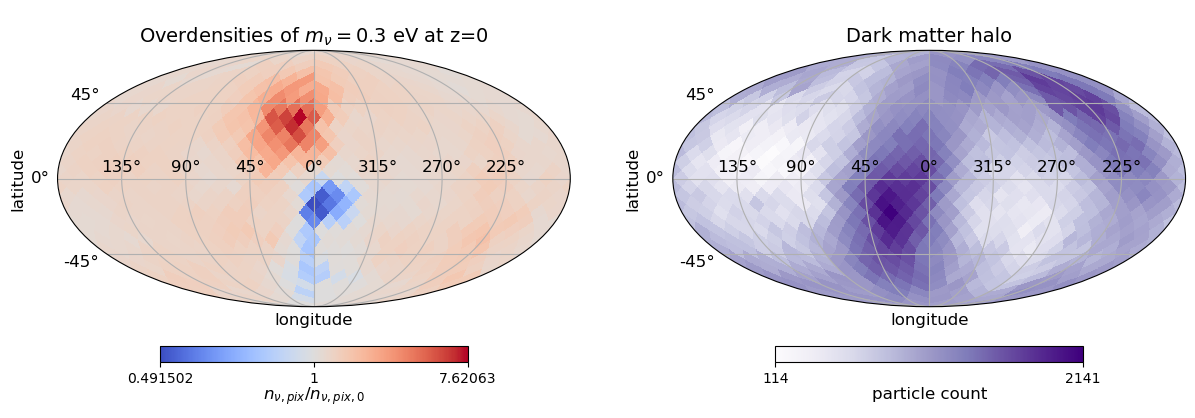

In [4]:
# Choose which halo to plot
halo_i = 1

# Load associated origID of chosen halo
halo_indices = jnp.load(
    f"{sim_folder}/halo_batch_0.6-2.0x1e+12.0_Msun_indices.npy")
haloID = halo_indices[halo_i-1]

# Choose which neutrino mass to plot
m_val = 0.3
nu_mass_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
m_idx = jnp.abs(nu_mass_range - m_val).argmin()

# Load corresponding number densities
CNB_dens_1mass = nu_dens[m_idx]
ic(CNB_dens_1mass.shape)
ic(CNB_dens_1mass.min(), CNB_dens_1mass.max())

CNB_skymap, DM_halo_skymap = SimPlot.skymaps_CNBxDM(
    nu_mass=m_val, 
    CNB_dens=CNB_dens_1mass, 
    DM_halo_pos=jnp.load(f"Data/halo_grids/DM_pos_origID{haloID}_snap_0036.npy"), 
    init_xyz=jnp.load(f"{sim_folder}/init_xyz_halo{halo_i}.npy"), 
    fig_path=f"figures/skymaps_CNBxDM_{sim_name}.pdf",
    args=Params())



## Phase-space Analysis

### Percentage in certain velocity range

In [8]:
def compute_percentages(v_arr, v_min, v_max, args):

    vels_z0 = v_arr[:, 0, :]

    # Condition for having neutrinos with velocities in range, today
    mags_z0 = jnp.linalg.norm(vels_z0, axis=-1)*args.kpc/args.s
    # ic(mags_z0.shape)
    cond = (v_min <= mags_z0) & (mags_z0 <= v_max)
    # ic(cond.shape)

    vels_range = v_arr[cond, ...]
    # ic(vels_range.shape)

    # Compute number densities for neutrinos in velocity range
    m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])
    dens_range = Physics.number_densities_mass_range(
        vels_range, m_picks, 4*args.Pi, args)

    dens_total = Physics.number_densities_mass_range(
        v_arr, m_picks, 4*args.Pi, args)

    # Percentages 
    perc_range = dens_range/dens_total*100
    percs = [f"{perc:.3f}" for perc in perc_range]
    print(percs)


# Pick a halo
halo_i = 1

# Load velocities
vels = jnp.array(
    [jnp.load(f"{sim_folder}/vectors_halo{i+1}.npy") for i in range(10)]
)[0, ..., 3:].reshape((-1, 2, 3))
# ic(vels.shape)

vels_z0 = vels[:, 0, :]
# ic(vels_z0.shape)

vels_only_z0s = jnp.repeat(jnp.expand_dims(vels_z0, axis=1), repeats=2, axis=1)
# ic(vels_only_z0s.shape)

# Pick velocity range (as in https://arxiv.org/abs/1305.2454), units of c


v_min = 0.01
v_max = 0.14
print(f"Velocities between {v_min}c and {v_max}c :")
print(f"  0.01      0.05       0.1      0.2       0.3   eV")
compute_percentages(v_arr=vels, v_min=v_min, v_max=v_max, args=Params())
compute_percentages(v_arr=vels_only_z0s, v_min=v_min, v_max=v_max, args=Params())

print("\n")

v_min = 0.001
v_max = 0.01
print(f"Velocities between {v_min}c and {v_max}c :")
print(f"  0.01      0.05       0.1      0.2       0.3   eV")
compute_percentages(v_arr=vels, v_min=v_min, v_max=v_max, args=Params())
compute_percentages(v_arr=vels_only_z0s, v_min=v_min, v_max=v_max, args=Params())

Velocities between 0.01c and 0.14c :
  0.01      0.05       0.1      0.2       0.3   eV
['97.195', '45.398', '6.266', '0.041', '0.000']
['97.200', '46.090', '6.861', '0.058', '0.000']


Velocities between 0.001c and 0.01c :
  0.01      0.05       0.1      0.2       0.3   eV
['1.518', '53.629', '91.993', '93.070', '86.819']
['1.511', '52.935', '91.260', '90.608', '77.145']


In [51]:
m_nu_Safdi = 0.05
v_Safdi = 160*(1+0)*(Params.eV/m_nu_Safdi)
ic(v_Safdi)

ic| v_Safdi: 3200.0


3200.0

### 4x4 phase-space distortions

In [ ]:
# Load necessary box and sim info.
with open(f'{self.sim_dir}/sim_parameters.yaml', 'r') as file:
    sim_setup = yaml.safe_load(file)

p_num = sim_setup['momentum_num']
p_start = sim_setup['momentum_start']
p_stop = sim_setup['momentum_stop']
phis = sim_setup['phis']
thetas = sim_setup['thetas']
init_dis_analytical = sim_setup['initial_haloGC_distance']

with open(f'{self.sim_dir}/box_parameters.yaml', 'r') as file:
    box_setup = yaml.safe_load(file)

# Box Cosmology.
box_H0 =  box_setup['Cosmology']['h']*100*km/s/Mpc
box_Omega_M = box_setup['Cosmology']['Omega_M']
box_Omega_L = box_setup['Cosmology']['Omega_L']

Rvir, Mvir, conc = self.get_halo_params()
Rvir_med = np.median(Rvir)
Mvir_med = np.median(Mvir)
conc_med = np.median(conc)
Rs_med = Rvir_med / conc_med
rho0_med = scale_density_NFW(
    c=conc_med, z=0.,
    H0=box_H0, Omega_M=box_Omega_M, Omega_L=box_Omega_L)

with open(f'{self.sim_dir}/box_parameters.yaml', 'r') as file:
    box_setup = yaml.safe_load(file)
DM_mass = box_setup['Content']['DM Mass [Msun]']*Msun

box_halos_p1_final = []
box_halos_y0_final = []
for halo_j in range(self.halo_num):

    vels_batches = self.vectors_numerical[halo_j,...,3:6]
    vels_in = vels_batches.reshape(-1, 100, 3)

    # Convert velocities to momenta.
    p_arr, y_arr = velocity_to_momentum(vels_in, self.mpicks)
    p0_arr = p_arr[...,0]
    p1_arr = p_arr[...,-1]
    y0_arr = y_arr[...,0]

    # Sort.
    ind = p0_arr.argsort(axis=-1)
    p1_sort = np.take_along_axis(p1_arr, ind, axis=-1)
    y0_sort = np.take_along_axis(y0_arr, ind, axis=-1)

    if most_likely:
        # Each velocity has a batch of neutrinos.
        # (min. of each to represent most (likely) clustered ones)
        m_len = (len(self.mpicks))
        p1_blocks = p1_sort.reshape((m_len, p_num, phis*thetas))
        p1_final = np.min(p1_blocks, axis=-1)
        y0_blocks = y0_sort.reshape((m_len, p_num, phis*thetas))
        y0_final = y0_blocks[...,0]
    else:
        p1_final = p1_sort
        y0_final = y0_sort

    box_halos_p1_final.append(p1_final)
    box_halos_y0_final.append(y0_final)

box_halos_p1_final = np.array(box_halos_p1_final)
box_halos_y0_final = np.array(box_halos_y0_final)

p1_median = np.median(box_halos_p1_final, axis=0)
p1_perc2p5 = np.percentile(box_halos_p1_final, q=2.5, axis=0)
p1_perc97p5 = np.percentile(box_halos_p1_final, q=97.5, axis=0)
p1_perc16 = np.percentile(box_halos_p1_final, q=16, axis=0)
p1_perc84 = np.percentile(box_halos_p1_final, q=84, axis=0)

y0_median = np.median(box_halos_y0_final, axis=0)
y0_perc2p5 = np.percentile(box_halos_y0_final, q=2.5, axis=0)
y0_perc97p5 = np.percentile(box_halos_y0_final, q=97.5, axis=0)
y0_perc16 = np.percentile(box_halos_y0_final, q=16, axis=0)
y0_perc84 = np.percentile(box_halos_y0_final, q=84, axis=0)

# Fermi Dirac of the final momenta.
FDvals_median = Fermi_Dirac(p1_median)
FDvals_perc2p5 = Fermi_Dirac(p1_perc2p5)
FDvals_perc97p5 = Fermi_Dirac(p1_perc97p5)
FDvals_perc16 = Fermi_Dirac(p1_perc16)
FDvals_perc84 = Fermi_Dirac(p1_perc84)

fig, axs = plt.subplots(2,2, figsize=(12,12))

percentages_esc = np.zeros(len(self.mpicks))
for j, m_nu in enumerate(self.mpicks):
    k = j  # k selects the element(s) for the current neutrino mass

    # Indices for axes of 2x2 subplots.
    i = 0
    if j in (2,3):
        i = 1
        j -= 2

    individual = False

    if individual:
        for xs, ys in zip(box_halos_y0_final, box_halos_p1_final):
            FDs = Fermi_Dirac(ys)

            axs[i,j].plot(
                xs[k], FDs[k], c='dodgerblue', alpha=0.8
            )

    else:
        # Simulation phase-space distr. of neutrinos today.
        axs[i,j].plot(
            y0_median[k], FDvals_median[k], label='box halos (median)', c='blue', alpha=0.9)

        axs[i,j].fill_between(
            y0_median[k], FDvals_perc2p5[k], FDvals_perc97p5[k],
            color='blue', alpha=0.2, 
            label='2.5-97.5 % C.L.')
        
        axs[i,j].fill_between(
            y0_median[k], FDvals_perc16[k], FDvals_perc84[k],
            color='blue', alpha=0.3, 
            label='16-84 % C.L.')
    
    # Fermi-Dirac phase-space distr.
    pOG = np.geomspace(
        p_start*T_CNB, p_stop*T_CNB, FDvals_median.shape[-1])
    FDvalsOG = Fermi_Dirac(pOG)
    yOG = pOG/T_CNB
    axs[i,j].plot(
        yOG, FDvalsOG, 
        label='Fermi-Dirac', c='magenta', ls=':', alpha=0.85)

    # Escape momentum for each box halo.

    # Read total DM mass by summing particles.
    # sim_parent = str(pathlib.Path(self.sim_dir).parent)
    # DM_counts = np.zeros(len(self.halo_indices))
    # for ii, ID in enumerate(self.halo_indices):
    #     DM_count = np.load(
    #         f'{sim_parent}/data_precalculations/DM_count_origID{ID}_snap_0036.npy')
    #     DM_counts[ii] = np.sum(DM_count)
    
    # M_tot = DM_counts*DM_mass
    # rho_crit = fct_rho_crit(0, box_H0, box_Omega_M, box_Omega_L)
    # Rvir = np.cbrt(3*M_tot/(4*Pi*100*rho_crit))
    # Rs = Rvir/conc

    # rho0 = scale_density_NFW(
    #     c=conc, z=0.,
    #     H0=box_H0, Omega_M=box_Omega_M, Omega_L=box_Omega_L)

    # _, y_esc = escape_momentum(
    #     x_i=self.init_xyz*kpc, 
    #     R_vir=Rvir, R_s=Rs, rho_0=rho0, 
    #     m_nu_eV=m_nu)

    # Using get_halo_params function, so x_200 values.
    Rs = Rvir/conc
    rho0 = scale_density_NFW(
        c=conc, z=0.,
        H0=box_H0, Omega_M=box_Omega_M, Omega_L=box_Omega_L)

    _, y_esc = escape_momentum(
        x_i=self.init_xyz*kpc, 
        R_vir=Rvir*kpc, R_s=Rs*kpc, rho_0=rho0, 
        m_nu_eV=m_nu)

    y_esc_med = np.median(y_esc, axis=0)
    y_esc_perc2p5 = np.percentile(y_esc, q=2.5, axis=0)
    y_esc_perc97p5 = np.percentile(y_esc, q=97.5, axis=0)
    y_esc_perc16 = np.percentile(y_esc, q=16, axis=0)
    y_esc_perc84 = np.percentile(y_esc, q=84, axis=0)

    axs[i,j].axvline(
        y_esc_med, c='black', ls='-.', label='escape momentum')
    
    y_min, y_max = axs[i, j].get_ylim()

    axs[i, j].fill_betweenx(
        [y_min, y_max], x1=y_esc_perc2p5, x2=y_esc_perc97p5, 
        color='black', alpha=0.2, 
        # label='y_esc: 2.5-97.5 % C.L.'
        )
    
    axs[i, j].fill_betweenx(
        [y_min, y_max], x1=y_esc_perc16, x2=y_esc_perc84, 
        color='black', alpha=0.3, 
        # label='y_esc: 16-84 % C.L.'
        )

    # Plot styling.
    axs[i,j].set_title(f'{m_nu} eV')

    log_scale = True

    if log_scale:
        lin_or_log = 'log'
        axs[i,j].set_ylim(1e-2, 1e0)
        axs[i,j].set_xlim(p_start, 1e1)
        axs[i,j].set_xscale('log')
        axs[i,j].set_yscale('log')
    else:
        lin_or_log = 'linear'
        x_max_lims = [0.5, 1.5, 2.5, 7]
        axs[i,j].set_xlim(np.min(y0_median[k]), x_max_lims[k])
        

    ### --------------------------------------- ###
    ### Excourse: Percentages of distributions. ###
    ### --------------------------------------- ###

    ### Normal Fermi-Dirac distribution.

    # Total area (for normalization).
    orig_mom = np.geomspace(0.001*T_CNB, 1000*T_CNB, 100_000)
    FD_orig = Fermi_Dirac(orig_mom)
    FD1_norm = np.trapz(
        orig_mom**3*FD_orig, x=np.log(orig_mom))
    
    # Percentage covered withing momentum interval.
    p_interval = np.geomspace(0.01*T_CNB, y_esc_med*T_CNB, 10_000)
    FD_interval = Fermi_Dirac(p_interval)
    perc_interval = np.trapz(
        p_interval**3*FD_interval, x=np.log(p_interval))/FD1_norm
    ic(np.round(perc_interval*100, 2))


    ### "Distorted" Fermi-Dirac distribution due to clustering.
    
    # Total area (for normalization).
    all_mom = y0_median[k]*T_CNB
    FD2_norm = np.trapz(
        all_mom**3*FDvals_median[k], x=np.log(all_mom))

    
    # Clustered neutrino percentage using escape formula value.
    below_esc = (y0_median[k] <= y_esc_med)
    x_interval = y0_median[k][below_esc]*T_CNB
    y_interval = FDvals_median[k][below_esc]
    perc_esc = np.trapz(
        x_interval**3*y_interval, x=np.log(x_interval))/FD2_norm
    percentages_esc[k] = np.round(perc_esc*100, 2)
    ic(np.round(perc_esc*100, 2))


    if m_nu == self.mpicks[-1]:
        axs[i,j].legend(
            loc='lower left', borderpad=0.5, labelspacing=0.5, 
            fontsize='medium')

# Common x-axis label.
fig.text(
    0.5, 0.05, r'$p/T_{\nu,0}$', 
    va='center', rotation='horizontal', fontsize='x-large')

# Common y-axis label.
fig.text(
    0.04, 0.5, r'$f_\mathrm{today}$', 
    va='center', rotation='vertical', fontsize='x-large')

np.savetxt(
    f'clustered_neutrinos_percentages_esc.txt', percentages_esc)

plt.savefig(
    f'{self.fig_dir}/phase_space_numerical_{lin_or_log}.pdf', 
    bbox_inches='tight')
plt.close()

In [ ]:
def most_clustered():
    ...

    

plt.figure()
for i in range(4):
    ax = plt.subplot(221 + i)

    # ax. ...